<a target="_blank" href="https://colab.research.google.com/github/ACTCollaboration/DR6_Notebooks/blob/main/ACT_DR6_lensing_likelihood_with_cosmopower.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Cosmopower and the Lensing Likelihood

*Written by Karen Perez, Boris Bolliet and the ACT collaboration*

---

This notebook will demonstrate how to work with the ACT Data Release 6 (DR6) lensing likelihood using Cosmopower. This is done by loading information about the ACT lensing data, including the covariance matrix and power spectrum, and running MCMC to estimate cosmological parameters. The MCMC library that we will use here is `Cobaya` ([arxiv](https://arxiv.org/abs/2005.05290), [ASCL](https://ascl.net/1910.019)), which is a general purpose statistical framework used in cosmological parameter estimation.

In MCMC, we have to sample the parameter space and generate a theoretical power spectrum many times. Traditionally, this is done using Boltzmann theory codes such as CLASS ([code](https://github.com/lesgourg/class_public), [paper](https://arxiv.org/abs/1104.2932)) or CAMB ([code](https://github.com/cmbant/CAMB/), [paper](https://ui.adsabs.harvard.edu/abs/2000ApJ...538..473L/abstract)). In this notebook, we instead make use of emulators made with Cosmopower ([code](https://github.com/alessiospuriomancini/cosmopower), [paper](https://arxiv.org/abs/2106.03846)), a set of trained neural networks that significantly speeds up the computation of theory power spectra and parameter estimation. These specific emulators here are trained with Stage IV accuracy requirements, as reported [here](https://arxiv.org/abs/2303.01591).

Currently, the cosmopower emulators are wrapped within the class_sz ([code](https://github.com/CLASS-SZ/class_sz), [paper](https://inspirehep.net/literature/2715411)) code, which easily allows for exact evaluation of background and thermodynamics quantities while calling the cosmopower emulators to predict the CMB spectra.

### ACT DR6 data products


The data for this release is publicly available on [Lambda](https://lambda.gsfc.nasa.gov/product/act/actadv_prod_table.html) and a full discussion of the ACT DR6 lensing analysis can be found in [Qu et al. (2023) ](https://arxiv.org/abs/2304.05202), [Madhavacheril et al. (2023)](https://arxiv.org/abs/2304.05203), [MacCrann et al. (2023)](https://arxiv.org/abs/2304.05196) and [Farren et al. (2023)](https://arxiv.org/abs/2309.05659).

For more information on `Cosmopower` readers can refer to [Spuria Mancini et al. (2021)](https://arxiv.org/abs/2106.03846) and the code can be found on [github](https://github.com/alessiospuriomancini/cosmopower).

### Further background
For anyone who would like a bit more background in CMB analysis we recommend a few other resources from ACT at the end of this notebook.

## Package instalation and setup
First, we need to install `Cobaya`, `Cosmopower` and all the dependencies to make them interface with each other. We will also install the BAO likelihoods, available via `Cobaya`, as well as the ACT DR6 lensing likelihood. Since we are installing a lot of libraries, the following cell will take ~20 minutes to run.

In [1]:
%%capture
!pip install tensorflow==2.13.0
!pip install tensorflow_probability==0.21.0

In [2]:
%%capture
!pwd
!pip install cosmopower
!pip install mcfit
!sudo apt install libgsl-dev
!sudo apt install fftw3-dev
!rm -rf class_sz
!git clone https://github.com/CLASS-SZ/class_sz.git
%cd class_sz
!mv Makefile Makefile_os
!mv Makefile_linux Makefile
!make clean
!make
%cd python
!pip install -e .
%cd classy_szfast/classy_szfast/
!scp config.py config_old.py
!sed -i 's/cosmopower-organization\//\/content\/cosmopower-organization\//' config.py
%cd /content/class_sz/python/classy_szfast/
!pip install -e .
%cd /content/class_sz/python/
!pip install -e .
%cd /content
!rm -rf cosmopower-organization
!mkdir cosmopower-organization
%cd /content/cosmopower-organization
!git clone https://github.com/cosmopower-organization/lcdm.git
!git clone https://github.com/cosmopower-organization/mnu.git
!git clone https://github.com/cosmopower-organization/neff.git
!git clone https://github.com/cosmopower-organization/wcdm.git
!git clone https://github.com/cosmopower-organization/reactemu-fr.git
!git clone https://github.com/cosmopower-organization/ede.git
%cd /content/
import sys
sys.path.insert(1, "/content/class_sz/python")
sys.path.insert(1, "/content/class_sz/python/classy_szfast")

In [4]:
%%capture
%cd /content/
!pip install cobaya
!mkdir cosmo_pkgs
!cobaya-install cosmo -p /content/cosmo_pkgs
%cd /content/
!pip install act_dr6_lenslike
import act_dr6_lenslike
import os
actdr6path = act_dr6_lenslike.__file__
actdr6path = actdr6path+"/../"
actdr6path = os.path.normpath(actdr6path)
%cd $actdr6path
!mkdir -p data
%cd data/
!wget https://lambda.gsfc.nasa.gov/data/suborbital/ACT/ACT_dr6/likelihood/data/ACT_dr6_likelihood_v1.2.tgz
!tar -zxvf ACT_dr6_likelihood_v1.2.tgz
!rm ACT_dr6_likelihood_v1.2.tgz
%cd /content/

## Import the relevant packages

If everything in the cell above was installed correctly, then you should be able to import the following libraries.

In [5]:
import numpy as np
import cobaya
import cosmopower
import classy_sz
import scipy
import yaml
import os

from getdist import loadMCSamples, MCSamples
from getdist import plots

from cosmopower import cosmopower_NN
from cosmopower import cosmopower_PCAplusNN

import matplotlib
import matplotlib.pyplot as plt

import pprint

import subprocess

import act_dr6_lenslike
import time

%matplotlib inline
classy_sz.__file__

'/content/class_sz/python/classy_sz.cpython-310-x86_64-linux-gnu.so'

# Loading and formatting the `Cobaya` input `yaml` file

`Cobaya` requires 4 main components to do parameter estimation via MCMC:
* Likelihood: An external code/library that computes the likelihoods to be explored.
* Parameters: The list of parameters to be fixed, sampled or derived, along with their respective priors and values.
* Theory: The theory code to compute the observables used in the likelihoods. Traditionally, this would be either CAMB or CLASS, but in this notebook we will use `Cosmopower`.
* Sampler: The algorithm to sample the parameter space. In our case it will be MCMC.

Setup instructions such as paths and other parameters for each of these components can be written to a yaml file that is then
passed to Cobaya to perform parameter estimation. In this section, we will look at the contents of the yaml file, and edit some paths so that it works within this notebook and with all the packages we previously installed.

First, let's download the setup yaml file and the initial covariance matrix.

In [6]:
%%capture
!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/misc/lcdm_actplanck_baseline.classy_szfast_mcmc.yaml

!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/misc/lcdm_actplanck_baseline_covmat.covmat

In [7]:
filename = "lcdm_actplanck_baseline.classy_szfast_mcmc.yaml"
DR6_lensing_only_yaml = yaml.safe_load(open(filename))

The yaml file is now loaded into the notebook as python dictionary, and the setup instructions for the four different Cobaya components can be accessed as follows:

```
DR6_lensing_only_yaml["likelihood"]
DR6_lensing_only_yaml["theory"]
DR6_lensing_only_yaml["params"]
```



Let's take a look at the likelihood block. We will have to change the paths to the likelihoods we  just installed (ACTDR6LensLike and BAO).

In [8]:
path_to_bao_lkl = "/content/cosmo_pkgs/data"
DR6_lensing_only_yaml["likelihood"]['bao.sdss_dr12_lrg_bao_dmdh']['path'] = path_to_bao_lkl
DR6_lensing_only_yaml["likelihood"]['bao.sdss_dr16_lrg_bao_dmdh']['path'] = path_to_bao_lkl
DR6_lensing_only_yaml ["likelihood"]['bao.sdss_dr7_mgs']['path'] = path_to_bao_lkl
DR6_lensing_only_yaml["likelihood"]['bao.sixdf_2011_bao']['path'] = path_to_bao_lkl

Let's check that the changes were implemented.

In [9]:
pp = pprint.PrettyPrinter(indent=3)
pp.pprint(DR6_lensing_only_yaml["likelihood"])

{  'act_dr6_lenslike.ACTDR6LensLike': {  'apply_hartlap': True,
                                         'input_params': [],
                                         'kmax': 10,
                                         'lens_only': True,
                                         'limber': False,
                                         'lmax': 4000,
                                         'mock': False,
                                         'no_like_corrections': True,
                                         'nsims_act': 792.0,
                                         'nsims_planck': 400.0,
                                         'nz': 100,
                                         'output_params': [],
                                         'scale_cov': None,
                                         'speed': -1,
                                         'stop_at_error': True,
                                         'trim_lmax': 2998,
                                         'type

Now, let's take a look at the parameters section of the yaml file. Nothing has to be changed here, simply take a look at the parameters, and their priors or fixed values.

In [10]:
pp.pprint(DR6_lensing_only_yaml["params"])

{  'A': {'derived': 'lambda As: 1e9*As', 'latex': '10^9 A_\\mathrm{s}'},
   'As': {'derived': True, 'latex': 'A_\\mathrm{s}'},
   'H0': {  'latex': 'H_0',
            'prior': {'max': 90.0, 'min': 50.0},
            'proposal': 2.0,
            'ref': {'dist': 'norm', 'loc': 69.351243, 'scale': 2.0}},
   'S825': {  'derived': 'lambda sigma8, omegam: sigma8*(omegam/0.3)**0.25',
              'latex': '\\sigma_8 (\\Omega_\\mathrm{m}/0.3)^{0.25}'},
   'S85': {  'derived': 'lambda sigma8, omegam: sigma8*(omegam/0.3)**0.5',
             'latex': '\\sigma_8 (\\Omega_\\mathrm{m}/0.3)^{0.5}'},
   'YHe': {'derived': True, 'latex': 'Y_\\mathrm{P}'},
   'age': {'derived': True, 'latex': '{\\rm{Age}}/\\mathrm{Gyr}'},
   'chi2__BAO': {'derived': True, 'latex': '\\chi^2_\\mathrm{BAO}'},
   'logA': {  'latex': 'ln10^{10}A_s',
              'prior': {'max': 3.5, 'min': 2.5},
              'proposal': 0.12892144,
              'ref': {'dist': 'norm', 'loc': 2.9939341, 'scale': 0.12892144}},
   'n_s': {

Next, we will look at the theory code instructions in the yaml file. Notice how we are using `classy_szfast` (`Cosmopower` emulator) as the theory code!

In [11]:
pp.pprint(DR6_lensing_only_yaml["theory"])

{  'classy_szfast.classy_sz.classy_sz': {  'extra_args': {  'N_ncdm': 1,
                                                            'N_ur': 2.0328,
                                                            'k_pivot': 0.05,
                                                            'modes': 's,t',
                                                            'output': 'tCl,lCl,pCl',
                                                            'skip_background_and_thermo': 0,
                                                            'skip_pkl': 1,
                                                            'skip_pknl': 1},
                                           'lensing_lkl': 'ACT',
                                           'path': None,
                                           'speed': 0.2,
                                           'stop_at_error': True,
                                           'use_class_sz_fast_mode': 1}}


As usual, we will use MCMC as the sampler. To make the chains converge faster, we will change the Rminus1_stop value from 0.01 to 0.1. However, if you want to reproduce the contours in [Madhavacheril et al. (2023)](https://arxiv.org/abs/2304.05203), you will have to change this parameter back to 0.01.

In [12]:
DR6_lensing_only_yaml["sampler"]['mcmc']['Rminus1_stop']=0.1

In [13]:
pp.pprint(DR6_lensing_only_yaml["sampler"])

{  'mcmc': {  'Rminus1_cl_level': 0.95,
              'Rminus1_cl_stop': 0.2,
              'Rminus1_single_split': 4,
              'Rminus1_stop': 0.1,
              'burn_in': 0,
              'callback_every': None,
              'callback_function': None,
              'check_every': None,
              'covmat': 'auto',
              'covmat_params': None,
              'drag': False,
              'drag_limits': None,
              'fallback_covmat_scale': 4,
              'learn_every': '40d',
              'learn_proposal': True,
              'learn_proposal_Rminus1_max': 2.0,
              'learn_proposal_Rminus1_max_early': 30.0,
              'learn_proposal_Rminus1_min': 0.0,
              'max_samples': inf,
              'max_tries': 10000,
              'measure_speeds': True,
              'output_every': '60s',
              'oversample': None,
              'oversample_power': 0.4,
              'oversample_thin': True,
              'proposal_scale': 1.9,
         

We also need to update the path to the covariance matrix:

In [14]:
path_covmat = "lcdm_actplanck_baseline_covmat.covmat"
DR6_lensing_only_yaml["covmat"] = path_covmat
pp.pprint(DR6_lensing_only_yaml["covmat"])

'lcdm_actplanck_baseline_covmat.covmat'


We can also change the location and the prefix to all the files that Cobaya will output.

In [15]:
%cd /content/
!mkdir cobaya_output
DR6_lensing_only_yaml["output"] = "cobaya_output/lcdm_actplanck_baseline_notebook"

/content


Finally, we will save the dictionary into a new `yaml` file,  and then we will be ready to we are ready to run MCMC with `Cobaya` as the sampling framework and `Cosmopower` as the theory code.

In [16]:
file=open("/content/lcdm_actplanck_baseline.classy_szfast_mcmc.yaml","w")
yaml.dump(DR6_lensing_only_yaml,file)
file.close()

# Running the chains

We will now run MCMC with the `yaml` file we just edited and the command `cobaya-run`.

**This process can take about an hour** in google colab with

```
Rminus1_stop = 0.01
```

 and we generally recommend this type of analysis should not be done in a notebook.
 Here, we have chosen to run the code with

```
Rminus1_stop = 0.1
```

for speed and convenience.




In [17]:
%%time

t1 = time.time()
!cobaya-run /content/lcdm_actplanck_baseline.classy_szfast_mcmc.yaml -f

t2 = time.time()

delta_t = t2 - t1

[output] Output to be read-from/written-into folder 'cobaya_output', with prefix 'lcdm_actplanck_baseline_notebook'
2024-02-07 16:34:28.246716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[tensorflow] *WARNING* Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
2024-02-07 16:34:30.239098: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22525952 exceeds 10% of free system memory.
2024-02-07 16:34:30.332071: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22525952 exceeds 10% of free system memory.
2024-02-07 16:34:30.351758: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22525952 exceeds 10% of free system memory.
2024-02-07 16:34:30.580934: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22525952 exceeds 10% of free s

In [44]:
minutes_run = delta_t/60
minutes_run

24.835671377182006

Once the above cells are done, you've succesfully run your MCMC chains using the `Cosmopower` emulator as the theory code. Although this might have taken a long time in a notebook, if you were to use this code on a few more cores it would be an incredibly fast way of deriving your parameter constraints.

# Plotting

Now that we've run our chains, we can plot the parameter contours and take a look at them!

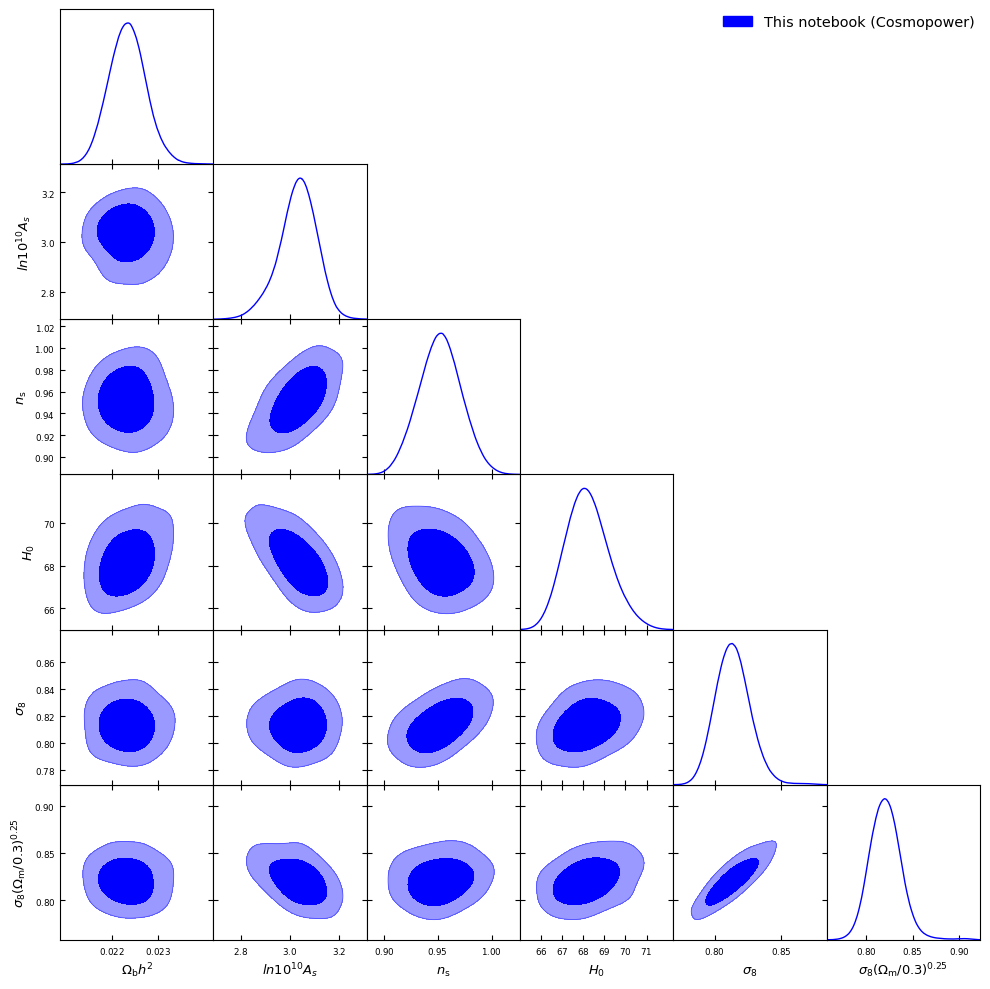

In [18]:
path_to_chains_dir = "/content/cobaya_output"
final_chain_dir_list = []
final_chain_dir_list.append(path_to_chains_dir +'/lcdm_actplanck_baseline_notebook')
i=0
readsamps = loadMCSamples(final_chain_dir_list[i],settings={'ignore_rows':0.3})
p = readsamps.getParams()
readsamps.addDerived(p.omega_b, name='ombh2', label='\Omega_\mathrm{b} h^2')
readsamps.addDerived(p.omega_cdm, name='omch2', label='\Omega_\mathrm{c} h^2')
#eadsamps.addDerived(p.n_s, name='n_s', label='n_\mathrm{s}')

g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 10

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=0 #uncomment if you want to display marg stats.

g.triangle_plot(readsamps,
    ['ombh2','logA','n_s','H0','sigma8','S825'],
    filled=[True,False],
    legend_labels=[ 'This notebook (Cosmopower)'],
    legend_loc='upper right',
    colors = ['blue','red','green','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'1','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}])

#g.export(path_to_chains_dir +'/DR6_lensing_only_contours_classy_szfast.pdf')

# Comparison to Madhavacheril et al. (2023).

To compare the results we obtain in this notebook with the ones in [Madhavacheril et al. (2023)](https://arxiv.org/abs/2304.05203), we can download the chains and overplot them with this notebook's chains.

In [19]:
%%capture
%cd /content/
!mkdir dr6-lensing/
%cd dr6-lensing
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.1.txt
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.2.txt
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.3.txt
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.4.txt
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.5.txt
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.6.txt
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.7.txt
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.8.txt
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.checkpoint
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.covmat
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.input.yaml
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.progress
!wget https://portal.nersc.gov/project/act/act_dr6_lensing/chains/dr6-lensing/lcdm_actplanck_baseline_167926925701.updated.yaml

%cd /content/

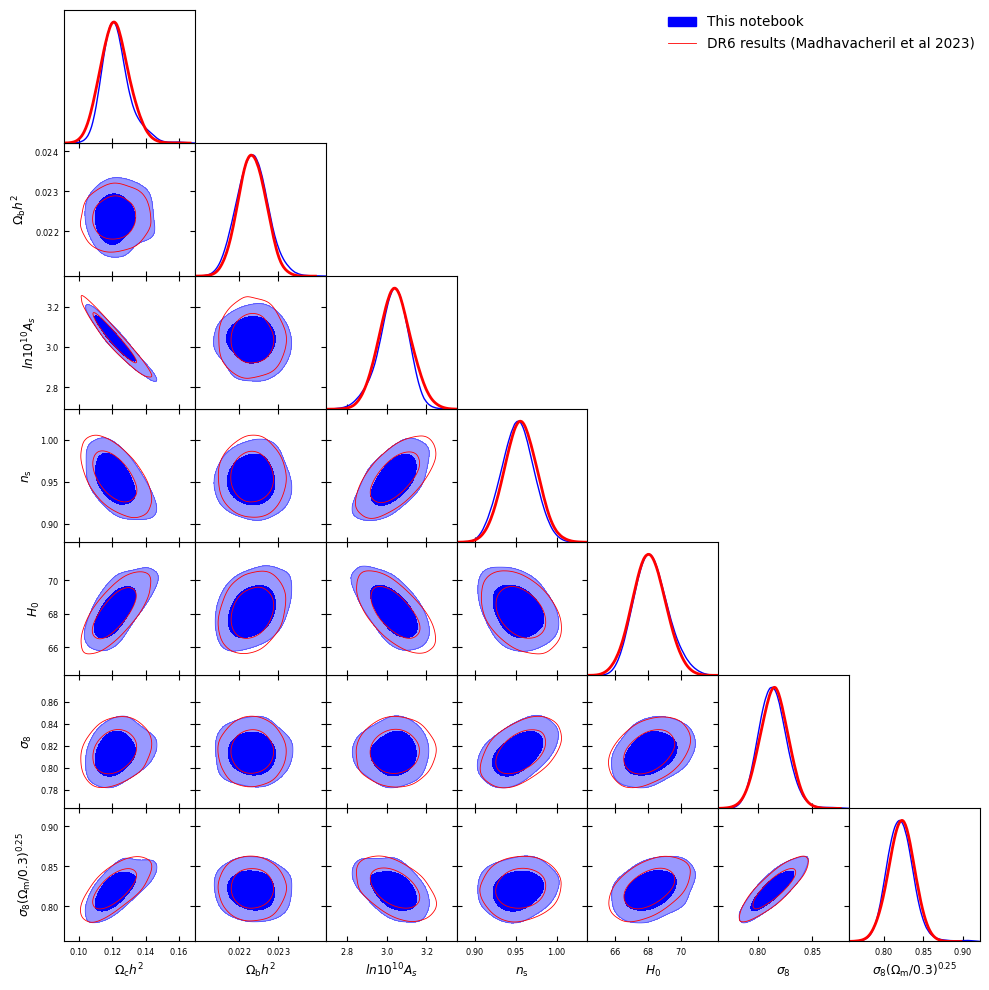

In [20]:
path_to_dr6_chains_dir = "/content/dr6-lensing"
final_chain_dr6_dir_list = []
i=0
final_chain_dr6_dir_list.append(path_to_dr6_chains_dir +'/lcdm_actplanck_baseline_167926925701')
readsamps_dr6 = loadMCSamples(final_chain_dr6_dir_list[i],settings={'ignore_rows':0.3})
all_samples_dr6 = []
samples_dr6 = readsamps_dr6
all_samples_dr6.append(samples_dr6)

g = plots.getSubplotPlotter()
g.settings.fig_width_inch = 10

g.settings.axes_fontsize = 10
g.settings.lab_fontsize =13

g.settings.legend_fontsize = 14
g.settings.alpha_filled_add=0.1
g.settings.colorbar_label_pad = 20.
g.settings.figure_legend_frame = False

g.settings.title_limit=0 #uncomment if you want to display marg stats.

g.triangle_plot([readsamps,readsamps_dr6],
    ['omch2','ombh2','logA','ns','H0','sigma8','S825'],
    filled=[True,False],
    legend_labels=['This notebook','DR6 results (Madhavacheril et al 2023)'],
    legend_loc='upper right',
    colors = ['blue','red'],
    line_args=[{'lw':'1','color':'blue'},{'lw':'2','color':'red'},{'lw':'1','color':'green'},{'lw':'1','color':'r'}])


# Related resources:

For more examples of how to use ACT data consider using:
- The DR6 Lensing notebooks available on github
- The DR4 and DR5 ACT notebooks available on [github](https://github.com/ACTCollaboration)
- The `pixell` notebooks which are available on the [`pixell` repo](https://github.com/simonsobs/pixell/tree/master) and describe how to work with maps from ACT